In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

In [ ]:
def plot_eurosat_everything(balance=True, init='all', agg='mean'):
    
    plt.rcParams['font.family'] = 'Nimbus Roman'
    plt.rcParams['font.size'] = 10

    csvname = "experiment_logs_balanced" if balance else "experiment_logs_unbalanced"
    print(csvname)
    
    df = pd.read_csv(f'/rootpath/{csvname}', header=None, names=['SamplingType', 'Seed', 'UUID', 'Value'])
    grouped_df = df.groupby(['SamplingType', 'Seed', 'UUID'])['Value']

    if balance:
        dataset = torch.load('/rootpath/eurosat/eurosat_balance/balance_42_train_y.pt').numpy()
    else:
        dataset = torch.load('/rootpath/eurosat/eurosat_unbalanced/imbalance_42_train_y.pt').numpy()
    dataset = np.unique(dataset.reshape(-1), return_counts=True)[1]

    sampling_strategies = pd.unique(df['SamplingType'])
    sampling_strategies_light = []

    tolight = lambda x: x.split("_")[0]
    
    for x in sampling_strategies:
        light = tolight(x)
        if light not in sampling_strategies_light:
            sampling_strategies_light.append(light)

    markers = {'*': 'star', '+': 'plus', ',': 'pixel', '.': 'point', '1': 'tri_down', '2': 'tri_up', '3': 'tri_left', '4': 'tri_right', '8': 'octagon', '<': 'triangle_left', '>': 'triangle_right', 'D': 'diamond', 'H': 'hexagon2', 'None': 'nothing', 'P': 'plus_filled', 'X': 'x_filled', '^': 'triangle_up', '_': 'hline', 'd': 'thin_diamond', 'h': 'hexagon1', 'none': 'nothing', 'o': 'circle', 'p': 'pentagon', 's': 'square', 'v': 'triangle_down', 'x': 'x', '|': 'vline', 0: 'tickleft', 1: 'tickright', 10: 'caretupbase', 11: 'caretdownbase', 2: 'tickup', 3: 'tickdown', 4: 'caretleft', 5: 'caretright', 6: 'caretup', 7: 'caretdown', 8: 'caretleftbase', 9: 'caretrightbase'}
    markers = list(markers.keys())
    markers = ['o', 'v', 's', 'h', '*', 'p', 'X', 'D', '^', '>']
    all_colors = ['red', 'blue', 'green', 'cyan', 'purple', 'orange', 'pink', 'brown', 'black', 'olive', 'gray', 'cyan', 'magenta', 'teal', 'maroon', 'navy', 'white', 'lime']
    all_colors.extend([
        'gold', 'silver', 'beige', 'coral', 'turquoise', 'indigo', 'lavender', 
        'violet', 'peach', 'mint', 'aqua', 'crimson'
    ])

    
    colors = {}
    values = {}
    labels = {}
    markerstyles = {}
    linestyles = {}


    print(len(sampling_strategies))
    print(len(all_colors))


    colors = {k: all_colors[v] for v, k in enumerate(sampling_strategies_light)}
    markerstyles = {k: markers[v] for v, k in enumerate(sampling_strategies_light)}
    
    
    for i, x in enumerate(list(grouped_df)):
        sampling_method = x[0][0]
        if init != 'all':
            if init not in sampling_method:
                continue
        experiment_id = x[0][1]
        if np.array(x[1]).shape[0] == 11:
            values.setdefault(sampling_method, []).append(np.array(x[1]))
            labels[sampling_method] = sampling_method
            linestyles[sampling_method] = '-'
    

    fig, ax = plt.subplots(figsize=(9,7))

    all_values = []
    for querystrat in values.keys():
        all_values.append(values[querystrat])
        vals = np.array(values[querystrat])
        mean_vals = np.mean(vals, axis=0)
        l = labels[querystrat].replace('_kmeans', ' K-Means')
        l = l.replace('_fps', ' FPS')
        l = l.replace('_random', ' Random')
        ax.plot(range(len(mean_vals)), mean_vals, c=colors[tolight(querystrat)], linestyle=linestyles[querystrat], label=l, marker=markerstyles[tolight(querystrat)])


    all_values = np.array(all_values) # (10, 5, 11)
    
    all_means = np.mean(all_values, axis=1) # (10, 11)
    all_means = np.mean(all_means, axis=0) # (11,)

    all_stds = np.std(all_values, axis=1) # (10, 11)
    all_stds = np.mean(all_stds, axis=0) # (11,)
    all_stds = np.sum(all_stds) # (1,)

    if "fps" in list(values.keys())[0]:
        inittext = "Farthest point sampling initialized"
    if "kmeans" in list(values.keys())[0]:
        inittext = "K-Means initialized"
    if "random" in list(values.keys())[0]:
        inittext = "Randomly initialized"        
    
    ax.text(0.2, 0.84, inittext)
    ax.text(0.2, 0.82, "Mean of last iteration: " + str(int(all_means[-1] * 100) / 100))
    ax.text(0.2, 0.80, "Sum over all mean standard deviations per iteration: " + str(int(all_stds * 100) / 100))

    ax.hlines(all_means[-1], 3, 10, linestyle='--')
    print('Last iteration mean ' + str(all_means[-1]))
    print('Sum standard deviations: '  + str(all_stds))

    
    plt.legend()
    
    
    #plt.plot(range(len(mean_vals)), mean_vals, c=colors[val], linestyle=linestyle[val], label=labels[val], marker=markerstyles[val], alpha=alf1)
    
    plt.xticks(range(11), [x for x in range(11)])
    plt.grid(alpha=0.2)
    #plt.yticks(range(0,100,10))
    #plt.legend(loc='bottom right')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.xlabel('Iteration')
    plt.yticks(np.arange(0.3, 0.9, 0.1))
    
    # Create the bar chart for class distribution
    plt.rcParams['font.family'] = 'Nimbus Roman'
    plt.rcParams['font.size'] = 8
    
    #class_distribution = np.unique(dataset, return_counts=True)[1]
    ax_inset = fig.add_axes([0.4, 0.2, 0.2, 0.2])  # Position the inset
    ax_inset.bar(range(1, 11), dataset, color='purple')
    if balance:
        ax_inset.set_title('Balanced EuroSAT Class Distr.')
    else:
        ax_inset.set_title('Unbalanced EuroSAT Class Distr.')
    ax_inset.set_xticks([])
    ax_inset.set_yticks([])
    
    filename = ''
    if "fps" in list(values.keys())[0]:
        filename += 'fps'
    if "kmeans" in list(values.keys())[0]:
        filename += 'kmeans'
    if "random" in list(values.keys())[0]:
        filename += 'random'

    if balance:
        filename += '_balance'
    else:
        filename += '_unbalance'
        
    plt.savefig(f'v2_{filename}.svg')
#    plt.legend()

# Eurosat Unbalanced

v3_unbalance_experiments_n16_e15
30
30
Last iteration mean 0.7798240740740741
Sum standard deviations: 0.6351154104493368


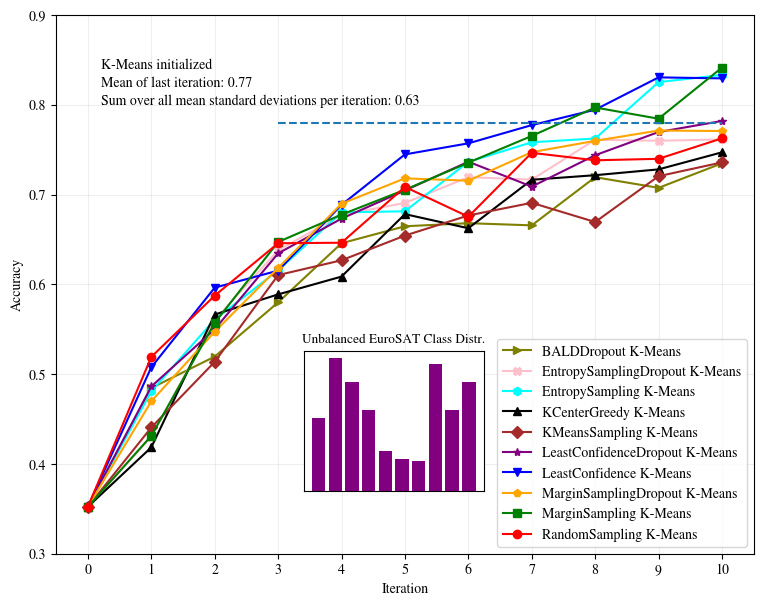

In [238]:
plot_eurosat_everything(init='kmeans', balance=False)

v3_unbalance_experiments_n16_e15
30
30
Last iteration mean 0.7849351851851851
Sum standard deviations: 0.5932819913805509


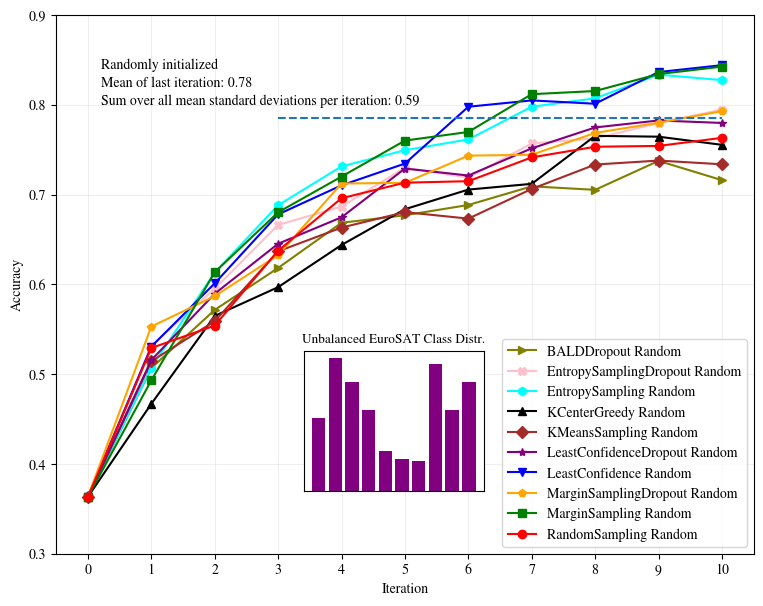

In [239]:
plot_eurosat_everything(init='random', balance=False)

v3_unbalance_experiments_n16_e15
30
30
Last iteration mean 0.7866388888888889
Sum standard deviations: 0.5874427922206985


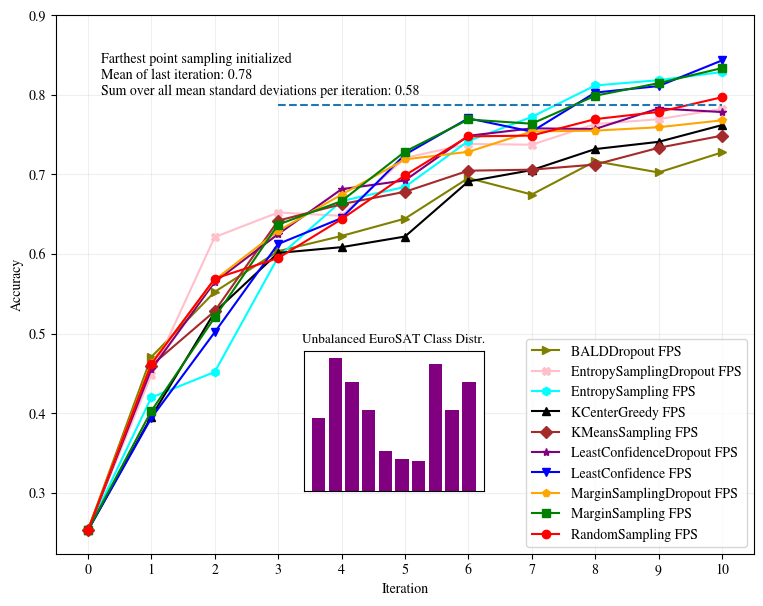

In [240]:
plot_eurosat_everything(init='fps', balance=False)

# Eurosat Balanced

v3_balance_experiments_n16_e15
30
30
Last iteration mean 0.8325277777777778
Sum standard deviations: 0.6799513298408846


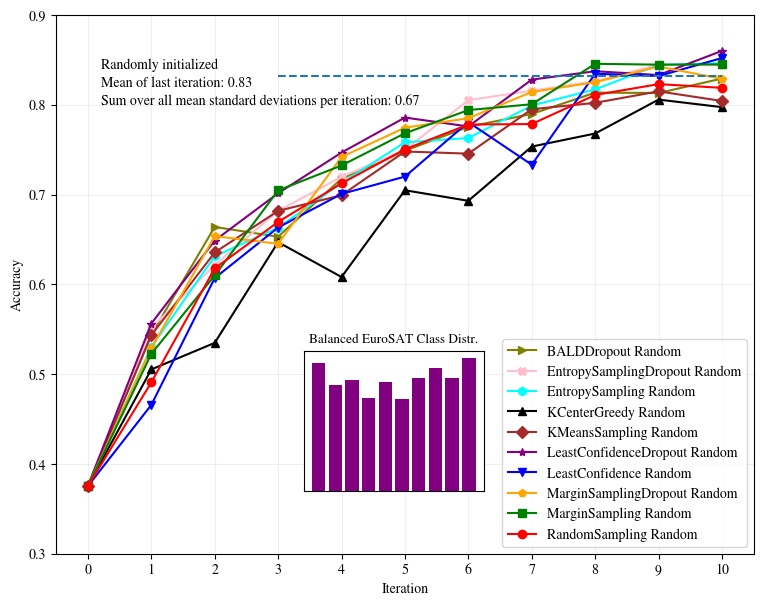

In [241]:
plot_eurosat_everything(init='random', balance=True)

v3_balance_experiments_n16_e15
30
30
Last iteration mean 0.8441666666666666
Sum standard deviations: 0.5541811226409724


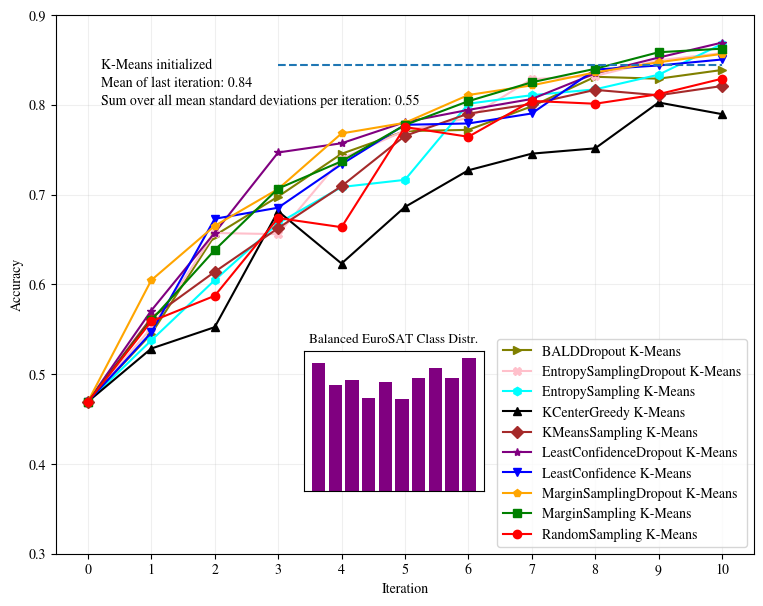

In [242]:
plot_eurosat_everything(init='kmeans', balance=True)

v3_balance_experiments_n16_e15
30
30
Last iteration mean 0.8198796296296298
Sum standard deviations: 0.6704434483038203


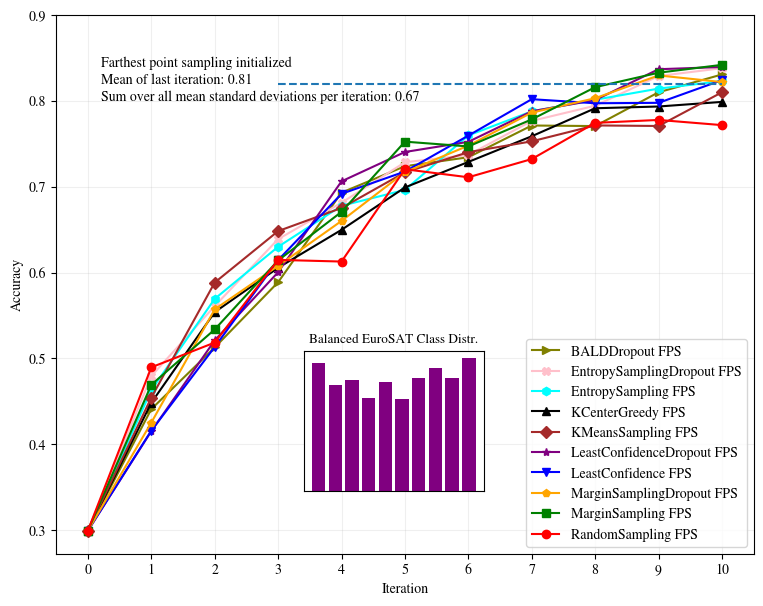

In [243]:
plot_eurosat_everything(init='fps', balance=True)

In [ ]:
def plot_dw_everything2(init='all', agg='mean'):
    
    plt.rcParams['font.family'] = 'Nimbus Roman'
    plt.rcParams['font.size'] = 10

    csvname = "experiment_logs"
    
    df = pd.read_csv(f'/rootpath/{csvname}', header=None, names=['SamplingType', 'UUID', 'Value'])
    grouped_df = df.groupby(['SamplingType', 'UUID'])['Value']

    dataset = torch.load('/rootpath/dynamicworld/128_dw_y_train.pt').numpy()
    dataset = np.unique(dataset.reshape(-1), return_counts=True)[1]

    sampling_strategies = pd.unique(df['SamplingType'])
    sampling_strategies_light = []

    tolight = lambda x: x.split("_")[0]
    
    for x in sampling_strategies:
        light = tolight(x)
        if light not in sampling_strategies_light:
            sampling_strategies_light.append(light)

    markers = {'*': 'star', '+': 'plus', ',': 'pixel', '.': 'point', '1': 'tri_down', '2': 'tri_up', '3': 'tri_left', '4': 'tri_right', '8': 'octagon', '<': 'triangle_left', '>': 'triangle_right', 'D': 'diamond', 'H': 'hexagon2', 'None': 'nothing', 'P': 'plus_filled', 'X': 'x_filled', '^': 'triangle_up', '_': 'hline', 'd': 'thin_diamond', 'h': 'hexagon1', 'none': 'nothing', 'o': 'circle', 'p': 'pentagon', 's': 'square', 'v': 'triangle_down', 'x': 'x', '|': 'vline', 0: 'tickleft', 1: 'tickright', 10: 'caretupbase', 11: 'caretdownbase', 2: 'tickup', 3: 'tickdown', 4: 'caretleft', 5: 'caretright', 6: 'caretup', 7: 'caretdown', 8: 'caretleftbase', 9: 'caretrightbase'}
    markers = list(markers.keys())
    markers = ['o', 'v', 's', 'h', '*', 'p', 'X', 'D', '^', '>']
    all_colors = ['red', 'blue', 'green', 'cyan', 'purple', 'orange', 'pink', 'brown', 'black', 'olive', 'gray', 'cyan', 'magenta', 'teal', 'maroon', 'navy', 'white', 'lime']
    all_colors.extend([
        'gold', 'silver', 'beige', 'coral', 'turquoise', 'indigo', 'lavender', 
        'violet', 'peach', 'mint', 'aqua', 'crimson'
    ])

    
    colors = {}
    values = {}
    labels = {}
    markerstyles = {}
    linestyles = {}


    colors = {k: all_colors[v] for v, k in enumerate(sampling_strategies_light)}
    markerstyles = {k: markers[v] for v, k in enumerate(sampling_strategies_light)}
    
    
    for i, x in enumerate(list(grouped_df)):
        sampling_method = x[0][0]
        if init != 'all':
            if init not in sampling_method:
                continue
        experiment_id = x[0][1]
        if np.array(x[1]).shape[0] == 11:
            values.setdefault(sampling_method, []).append(np.array(x[1]))
            labels[sampling_method] = sampling_method
            linestyles[sampling_method] = '-'
    

    fig, ax = plt.subplots(figsize=(9,7))

    all_values = []
    for querystrat in values.keys():
        all_values.append(values[querystrat])
        vals = np.array(values[querystrat])
        mean_vals = np.mean(vals, axis=0)
        l = labels[querystrat].replace('_kmeans', '')
        l = l.replace('_fps', ' ')
        l = l.replace('_Random', '')
        l = l.replace('random', '')
        l = l.replace('_1.0_', '')
        l = l.replace('_1.0','')
        ax.plot(range(len(mean_vals)), mean_vals, c=colors[tolight(querystrat)], linestyle=linestyles[querystrat], label=l, marker=markerstyles[tolight(querystrat)])


    all_values = np.array(all_values) # (10, 5, 11)
    
    all_means = np.mean(all_values, axis=1) # (10, 11)
    all_means = np.mean(all_means, axis=0) # (11,)

    all_stds = np.std(all_values, axis=1) # (10, 11)
    all_stds = np.mean(all_stds, axis=0) # (11,)
    all_stds = np.sum(all_stds) # (1,)

    if "fps" in list(values.keys())[0]:
        inittext = "Farthest point sampling initialized"
    if "kmeans" in list(values.keys())[0]:
        inittext = "K-Means initialized"
    if "random" in list(values.keys())[0]:
        inittext = "Randomly initialized"        
    
    ax.text(0.2, 0.32, inittext)
    ax.text(0.2, 0.31, "Mean of last iteration: " + str(int(round(all_means[-1] * 100)) / 100))
    ax.text(0.2, 0.30, "Sum over all mean standard deviations per iteration: " + str(int(round(all_stds * 100)) / 100))

    #ax.hlines(all_means[-1], 3, 10)
    print('Last iteration mean ' + str(all_means[-1]))
    print('Sum standard deviations: '  + str(all_stds))

    
    plt.legend()
    
    
    #plt.plot(range(len(mean_vals)), mean_vals, c=colors[val], linestyle=linestyle[val], label=labels[val], marker=markerstyles[val], alpha=alf1)
    
    plt.xticks(range(11), [x for x in range(11)])
    plt.grid(alpha=0.2)
    #plt.yticks(range(0,100,10))
    #plt.legend(loc='bottom right')
    plt.legend(loc='lower right')
    plt.ylabel('mIoU')
    plt.xlabel('Iteration')
    plt.yticks(np.arange(0.1, 0.36, 0.05))
    
    # Create the bar chart for class distribution
    plt.rcParams['font.family'] = 'Nimbus Roman'
    plt.rcParams['font.size'] = 8
    
    #class_distribution = np.unique(dataset, return_counts=True)[1]
    ax_inset = fig.add_axes([0.3, 0.15, 0.2, 0.2])  # Position the inset
    ax_inset.bar(range(1, 12), dataset, color='orange')
    
    ax_inset.set_title('Dynamic World Class Distr.')
    ax_inset.set_xticks([])
    ax_inset.set_yticks([])
    
    filename = ''
    if "fps" in list(values.keys())[0]:
        filename += 'fps'
    if "kmeans" in list(values.keys())[0]:
        filename += 'kmeans'
    if "random" in list(values.keys())[0]:
        filename += 'random'

    
    filename += '_dw'
        
    plt.savefig(f'v2_{filename}.svg')
#    plt.legend()

# Semantic Segmentation Dynamic World

## Random

Last iteration mean 0.2818872320313087
Sum standard deviations: 0.26047753644651334


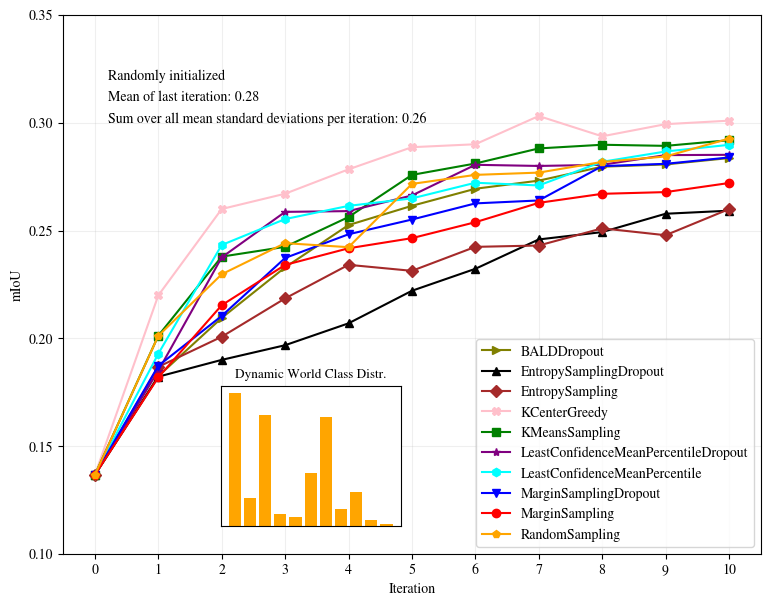

In [246]:
plot_dw_everything2(init='random')

## K-Means initialized

Last iteration mean 0.2852286366564602
Sum standard deviations: 0.24721060187138288


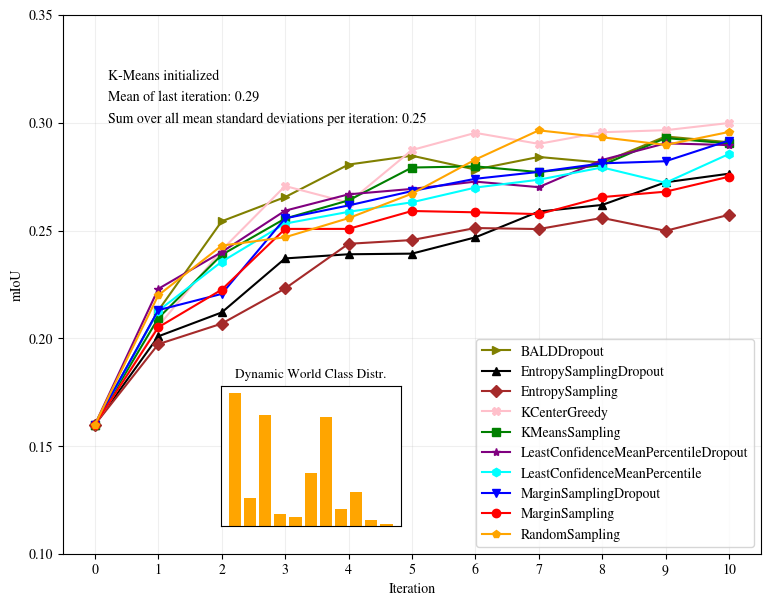

In [247]:
plot_dw_everything2(init='kmeans')

# FPS initialized

Last iteration mean 0.28988602204781555
Sum standard deviations: 0.2179960227724372


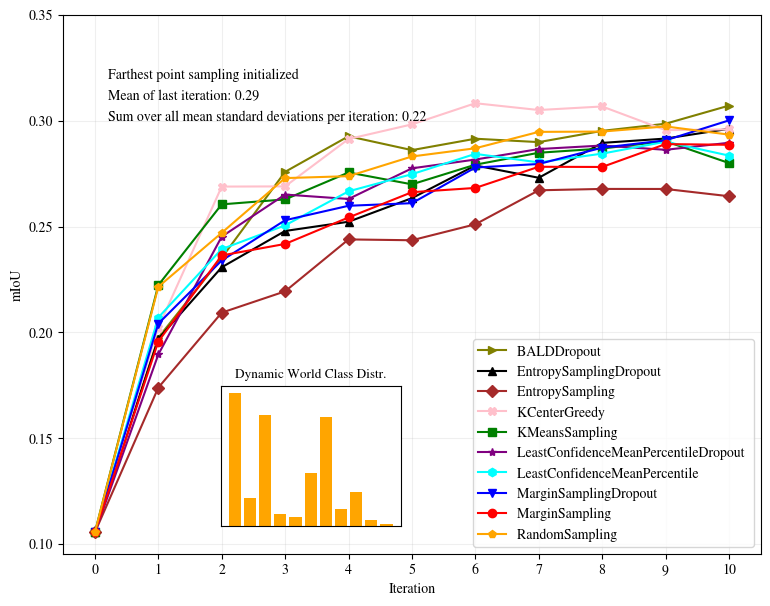

In [248]:
plot_dw_everything2(init='fps')